## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pywt
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available

2.2.0+cpu
False


## WaveLets Pre-Processing

In [3]:
def wavelet_transform(signal, wavelet='coif4', level=3):
    """
    Apply Discrete Wavelet Transform (DWT) on an RF signal.

    Args:
        signal (numpy array): Raw RF signal (48000, 1024, 2).
        wavelet (str): Type of wavelet to use (default = 'db4').
        level (int): Number of decomposition levels.

    Returns:
        Transformed signal (numpy array of the same shape).
    """
    transformed_signal = np.zeros_like(signal, dtype=np.float32)

    for index in range(signal.shape[0]):
        real_part = signal[index, :, 0]
        imag_part = signal[index, :, 1]

        # Convert to complex numbers
        complex_signal = real_part + 1j * imag_part

        # Apply Wavelet Transform (DWT)
        coeffs = pywt.wavedec(complex_signal, wavelet, level=level)

        # Flatten all coefficients
        flat_coeffs = np.concatenate([c.flatten() for c in coeffs])



        # Trim or pad to 1024
        if len(flat_coeffs) > 1024:
            approx_coeffs = flat_coeffs[:1024]
        elif len(approx_coeffs) < 1024:
            approx_coeffs = np.pad(flat_coeffs, (0, 1024 - len(flat_coeffs)), mode='constant')

        # Store transformed data
        transformed_signal[index, :, 0] = approx_coeffs.real + real_part
        transformed_signal[index, :, 1] = approx_coeffs.imag + imag_part

    return transformed_signal

## Data Processing

In [4]:
# Dataset Preparation
class H5Dataset(Dataset):
    def __init__(self, file_list, idx, transform=None):
        self.data = []
        self.labels = []
        self.snr = []
        for file in file_list:
            with h5py.File(file, 'r') as f:
                self.data.append(wavelet_transform(f['X'][:][idx]))
                self.labels.append(f['Y'][:][idx])
                self.snr.append(f['Z'][:][idx])
        self.data = np.vstack(self.data)
        self.labels = np.vstack(self.labels)
        self.snr = np.vstack(self.snr)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        z = self.snr[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(z, dtype=torch.float32)

## Model Definition

In [5]:
# Transformer Components
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):

        super(MultiHeadSelfAttention, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads

        self.query_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_dense = nn.Linear(embed_dim, embed_dim, bias=False)
        self.combine_heads = nn.Linear(embed_dim, embed_dim)

    def attention(self, query, key, value):
        score = torch.matmul(query, key.transpose(-2, -1))
        dim_key = torch.tensor(key.shape[-1], dtype=torch.float32)
        scaled_score = score / torch.sqrt(dim_key + 1e-9)
        weights = torch.softmax(scaled_score, dim=-1)
        output = torch.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.projection_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, inputs):
        batch_size = inputs.shape[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)
        attention = attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = attention.view(batch_size, -1, self.embed_dim)
        output = self.combine_heads(concat_attention)
        return output

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [7]:
# Model Definition
def proposed_model(X_train_shape, num_classes):
    embed_dim = 1024  # Embedding size for each token
    num_heads = 128  # Number of attention heads
    ff_dim = 256  # Hidden layer size in feed forward network inside transformer

    class Model(nn.Module):
      def __init__(self):

        super(Model, self).__init__()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.Conv2d):
                torch.nn.init.xavier_uniform_(layer.weight)
        self.reshape = nn.Linear(X_train_shape[-1], 1024*2)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.batch_norm = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.3)
        self.dense1 = nn.Linear(embed_dim, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(0.2)
        self.output_layer = nn.Linear(128, num_classes)

      def forward(self, x):
          x = x.view(-1, 2, 1024)
          x = self.transformer_block(x)
          x = self.global_avg_pool(x.transpose(1, 2)).squeeze(-1)
          x = self.batch_norm(x)
          x = self.dropout1(torch.selu(self.dense1(x)))
          x = self.dropout2(torch.selu(self.dense2(x)))
          x = self.dropout3(x)
          x = torch.softmax(self.output_layer(x), dim=-1)
          return x
    return Model()


## Model Training

In [8]:
#from sklearn.metrics import ConfusionMatrixDisplay
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels, snr in train_loader:
            inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels.max(1)[1]).sum().item()

        train_acc = 100. * correct / total
        train_losses.append(train_loss / total)
        train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / total:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_loader, criterion):
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  with torch.no_grad():
      for inputs, labels, snr in val_loader:
          inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item() * inputs.size(0)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += (predicted == labels.max(1)[1]).sum().item()

  val_loss /= total
  val_acc = 100. * correct / total
  return val_loss, val_acc


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

# File paths and dataset split
batch_size = 4096
dir_path =  'ExtractDataset'
f = h5py.File(dir_path + r'/part0.h5')

sample_num = f['X'].shape[0]
file_list = [dir_path + f"/part{i}.h5" for i in range(24)]
idx = np.random.choice(range(0,sample_num),size=60000)

train_size = int(0.8 * len(idx))
train_idx, test_idx = idx[:train_size], idx[train_size:]

train_dataset = H5Dataset(file_list, train_idx)
test_dataset = H5Dataset(file_list, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/300, Train Loss: 0.7086, Train Acc: 16.63%, Val Loss: 0.7070, Val Acc: 20.38%
Epoch 2/300, Train Loss: 0.7068, Train Acc: 20.99%, Val Loss: 0.7065, Val Acc: 21.95%
Epoch 3/300, Train Loss: 0.7063, Train Acc: 22.34%, Val Loss: 0.7061, Val Acc: 23.07%
Epoch 4/300, Train Loss: 0.7059, Train Acc: 23.57%, Val Loss: 0.7058, Val Acc: 24.13%
Epoch 5/300, Train Loss: 0.7054, Train Acc: 25.00%, Val Loss: 0.7055, Val Acc: 25.05%
Epoch 6/300, Train Loss: 0.7050, Train Acc: 26.11%, Val Loss: 0.7050, Val Acc: 26.51%
Epoch 7/300, Train Loss: 0.7046, Train Acc: 27.08%, Val Loss: 0.7048, Val Acc: 26.76%
Epoch 8/300, Train Loss: 0.7044, Train Acc: 27.74%, Val Loss: 0.7049, Val Acc: 26.48%
Epoch 9/300, Train Loss: 0.7042, Train Acc: 28.36%, Val Loss: 0.7046, Val Acc: 27.31%
Epoch 10/300, Train Loss: 0.7040, Train Acc: 28.84%, Val Loss: 0.7043, Val Acc: 28.08%
Epoch 11/300, Train Loss: 0.7038, Train Acc: 29.29%, Val Loss: 0.7042, Val Acc: 28.33%
Epoch 12/300, Train Loss: 0.7037, Train Acc: 29.71%,

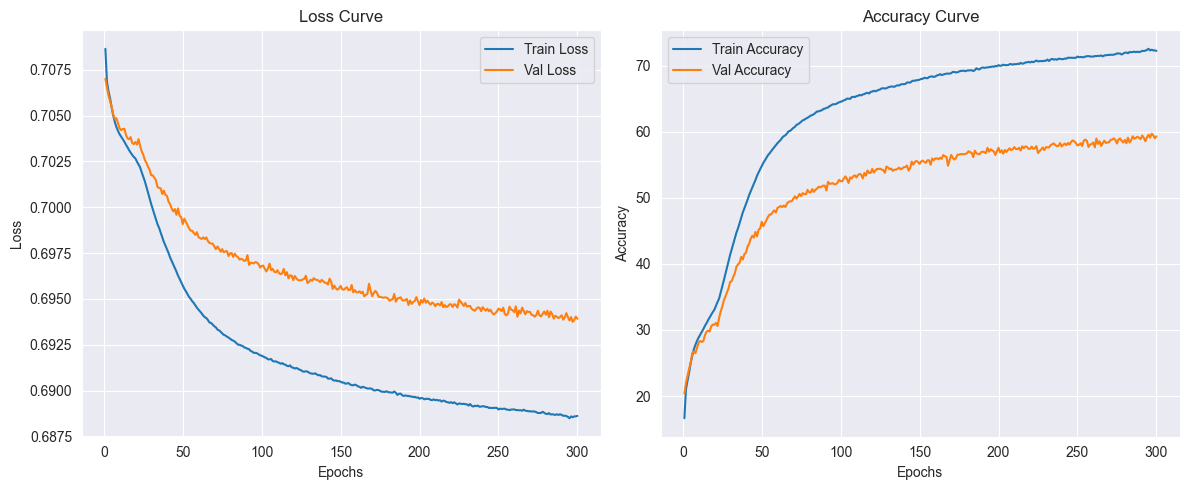

In [22]:
# Model, Loss, Optimizer
input_shape = train_dataset[0][0].shape
num_classes = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = proposed_model(input_shape, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train and Evaluate
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=300)

In [23]:
torch.save(model.state_dict(), 'Rf-finger-print-model.pth')

## Confusion Matrix

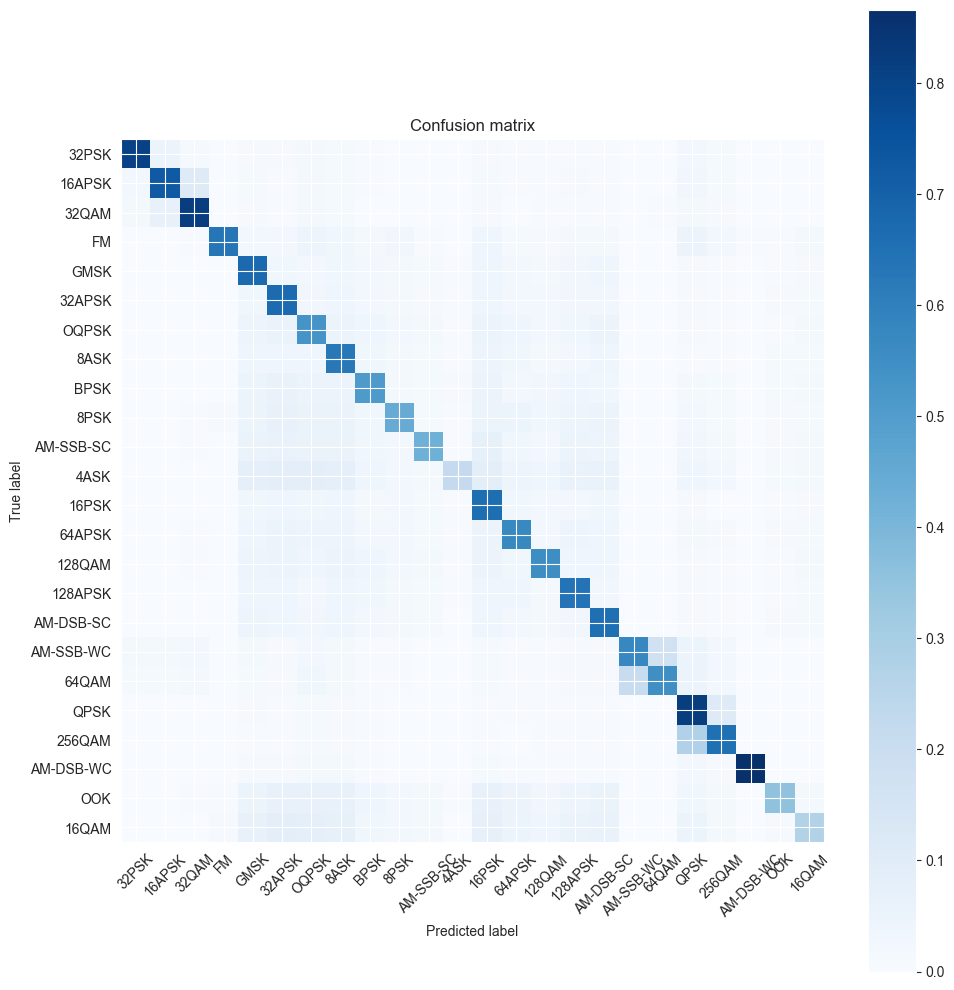

In [24]:
# Confusion Matrix
y_true = []
y_pred = []
outputs_test = []
model.eval()
with torch.no_grad():
    for inputs, labels , snr in test_loader:
        inputs, labels, snr = inputs.to(device), labels.to(device), snr.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        outputs_test.extend(outputs.cpu().numpy())
        y_true.extend(labels.max(1)[1].cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
classes=["32PSK", "16APSK", "32QAM", "FM", "GMSK", "32APSK", "OQPSK", "8ASK", "BPSK", "8PSK", "AM-SSB-SC", "4ASK", "16PSK", "64APSK", "128QAM", "128APSK", "AM-DSB-SC", "AM-SSB-WC", "64QAM", "QPSK", "256QAM", "AM-DSB-WC", "OOK", "16QAM"]
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
outputs_test= np.array(outputs_test)
for i in range(0, len(test_dataset)):
    j = list(test_dataset.labels[i,:]).index(1)
    k = int(np.argmax(outputs_test[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
# plot_confusion_matrix(y_true, y_pred, classes=["32PSK", "16APSK", "32QAM", "FM", "GMSK", "32APSK", "OQPSK", "8ASK", "BPSK", "8PSK", "AM-SSB-SC", "4ASK", "16PSK", "64APSK", "128QAM", "128APSK", "AM-DSB-SC", "AM-SSB-WC", "64QAM", "QPSK", "256QAM", "AM-DSB-WC", "OOK", "16QAM"])

## Modulation accuracy

In [41]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.8380625
16APSK 0.802375
32QAM 0.7565
FM 0.3749375
GMSK 0.4528125
32APSK 0.34725
OQPSK 0.791
8ASK 0.405
BPSK 0.8221875
8PSK 0.7835625
AM-SSB-SC 0.45675
4ASK 0.7818125
16PSK 0.47925
64APSK 0.7811875
128QAM 0.765375
128APSK 0.5609375
AM-DSB-SC 0.4388125
AM-SSB-WC 0.7528125
64QAM 0.6719375
QPSK 0.7974375
256QAM 0.699125
AM-DSB-WC 0.879625
OOK 0.4536875
16QAM 0.74475


## SNR accuracy

Overall Accuracy -20:  0.5518595041322314
Overall Accuracy -18:  0.5644119198312236
Overall Accuracy -16:  0.549660441426146
Overall Accuracy -14:  0.560038824181919
Overall Accuracy -12:  0.585291734197731
Overall Accuracy -10:  0.6278851315083199
Overall Accuracy -8:  0.6841333333333334
Overall Accuracy -6:  0.7237224157955865
Overall Accuracy -4:  0.7073317307692307
Overall Accuracy -2:  0.713673523206751


C:\Users\user1\AppData\Local\Temp\ipykernel_3836\3583432898.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Overall Accuracy 0:  0.7101591027647366
Overall Accuracy 2:  0.7022309711286089
Overall Accuracy 4:  0.6762452107279694
Overall Accuracy 6:  0.6720642443391258
Overall Accuracy 8:  0.6795952782462057
Overall Accuracy 10:  0.6532992036405005
Overall Accuracy 12:  0.6540823699421965
Overall Accuracy 14:  0.6516089108910891
Overall Accuracy 16:  0.6611251402918069
Overall Accuracy 18:  0.6581513260530422
Overall Accuracy 20:  0.6629438717067583
Overall Accuracy 22:  0.6655683690280065
Overall Accuracy 24:  0.6559728742827334
Overall Accuracy 26:  0.6587726523887973
Overall Accuracy 28:  0.6462570621468926
Overall Accuracy 30:  0.657695374800638


<Figure size 640x480 with 0 Axes>

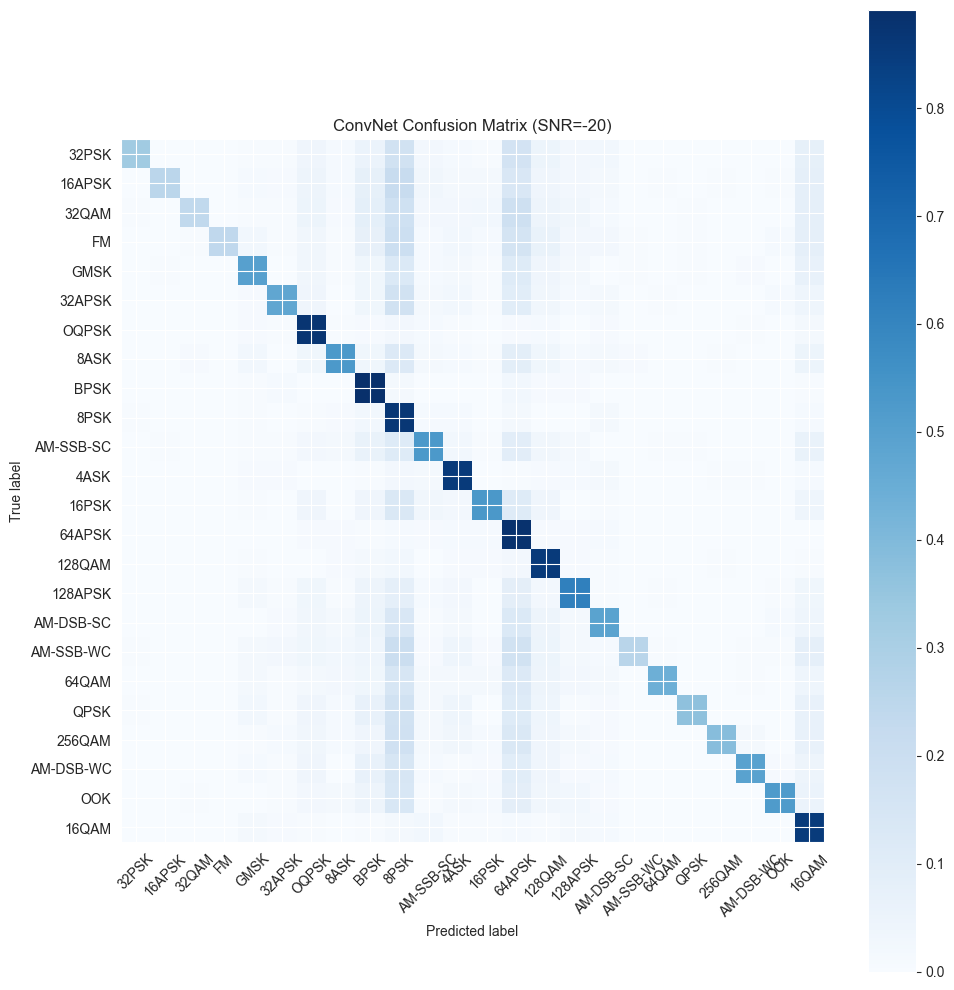

<Figure size 640x480 with 0 Axes>

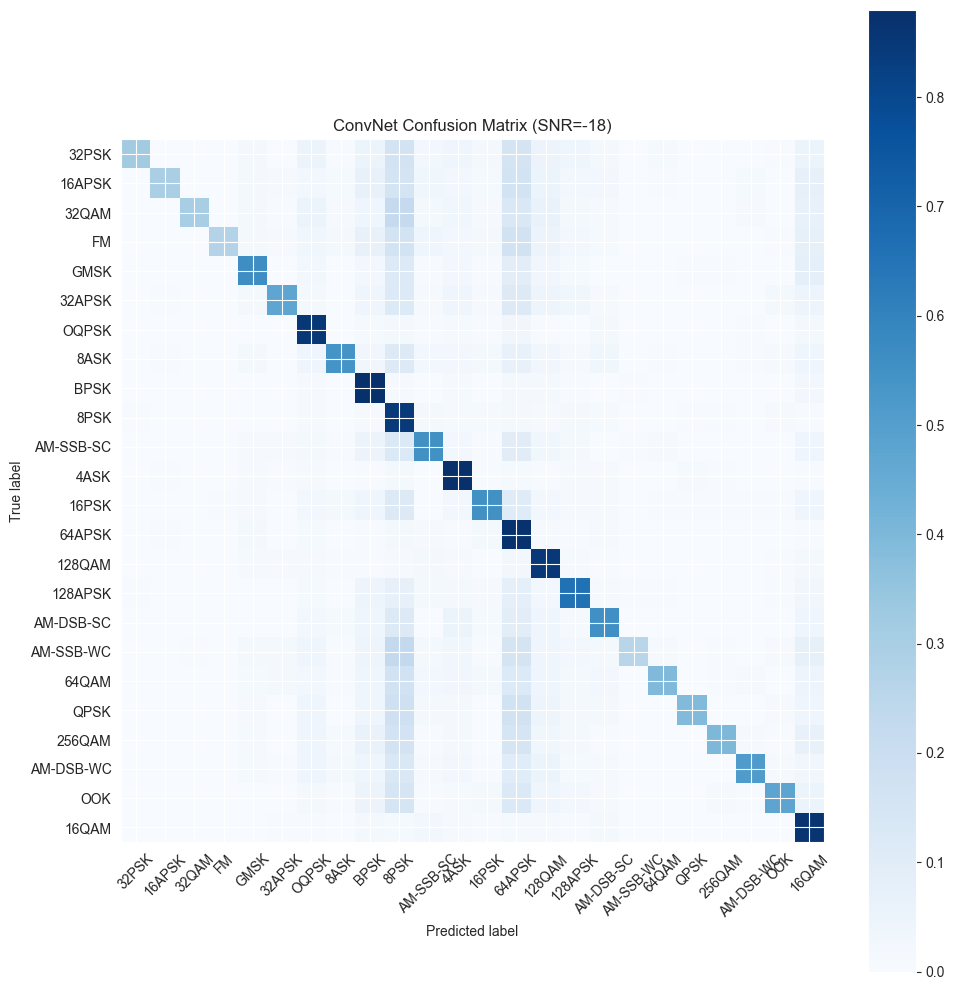

<Figure size 640x480 with 0 Axes>

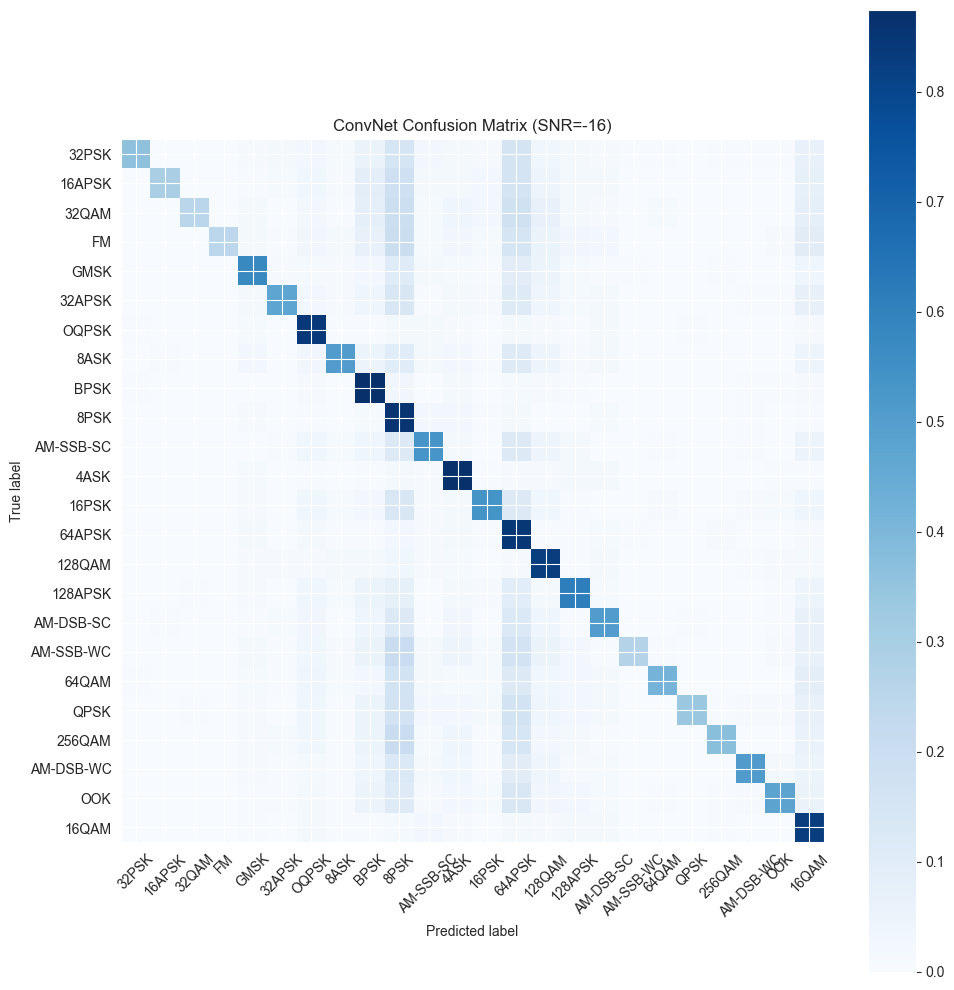

<Figure size 640x480 with 0 Axes>

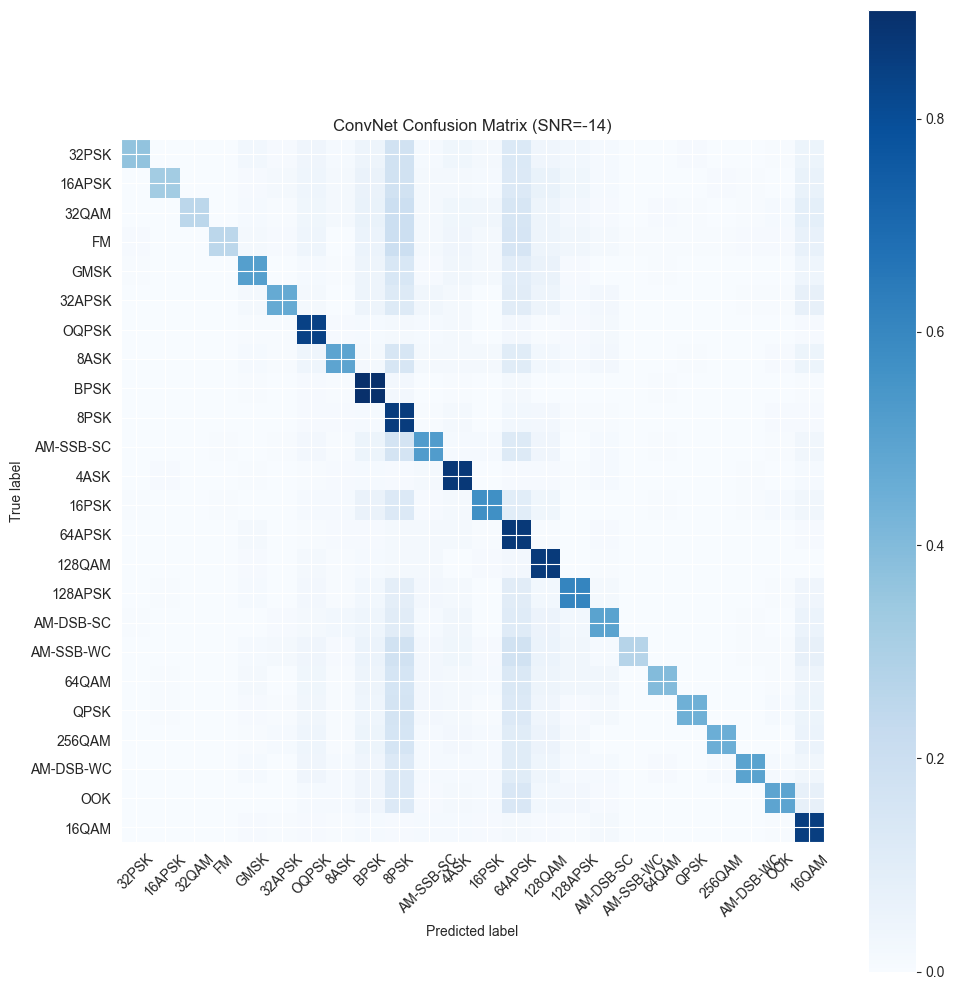

<Figure size 640x480 with 0 Axes>

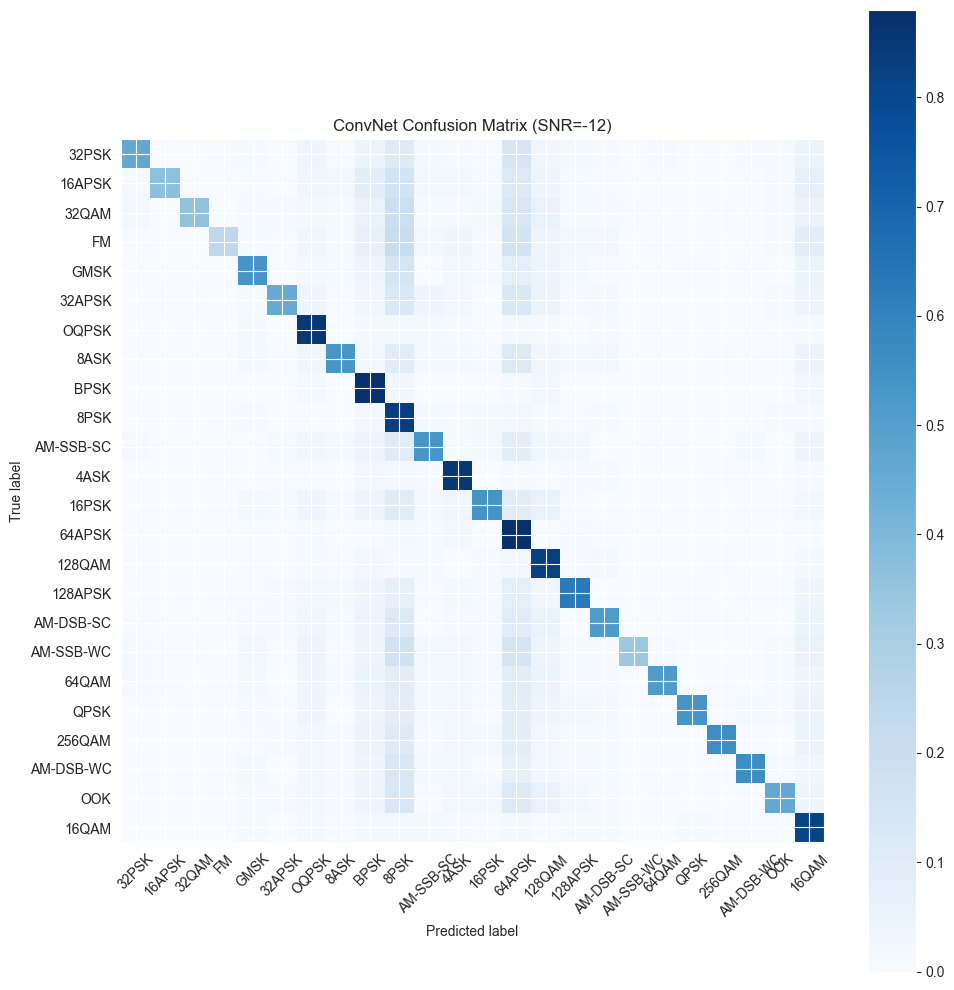

<Figure size 640x480 with 0 Axes>

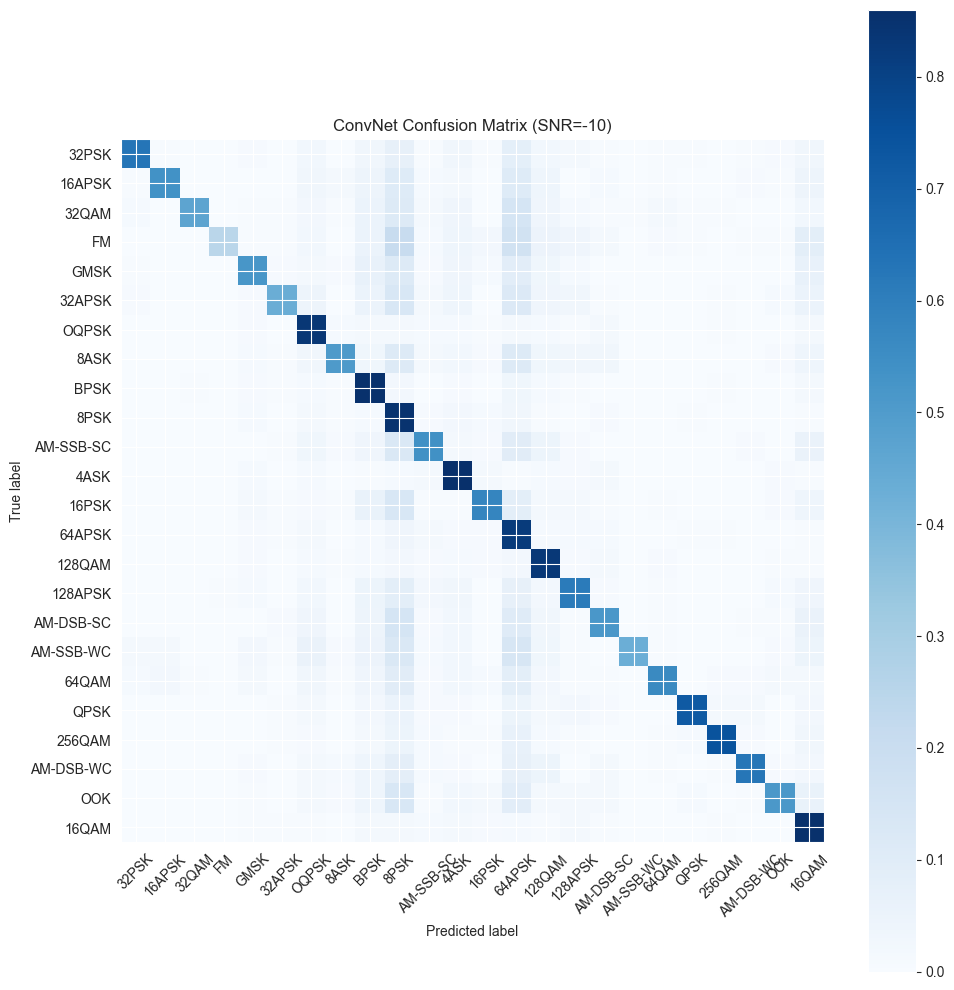

<Figure size 640x480 with 0 Axes>

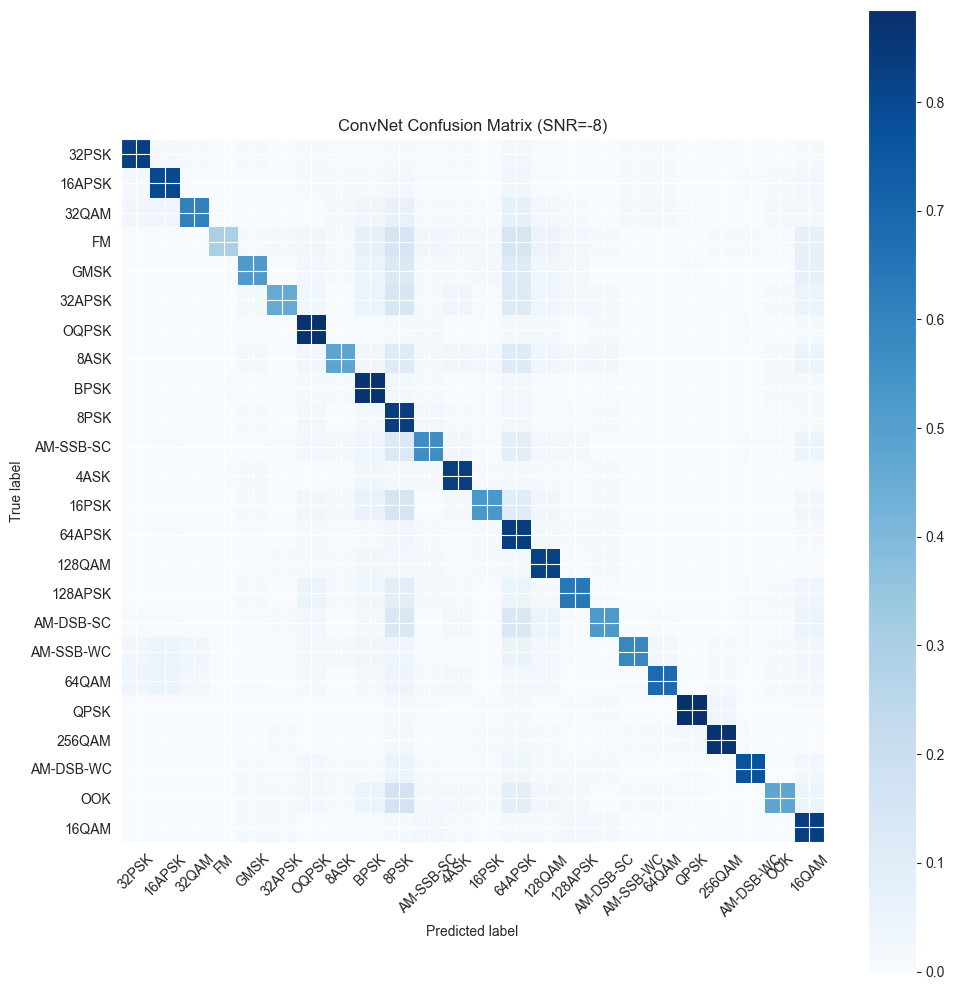

<Figure size 640x480 with 0 Axes>

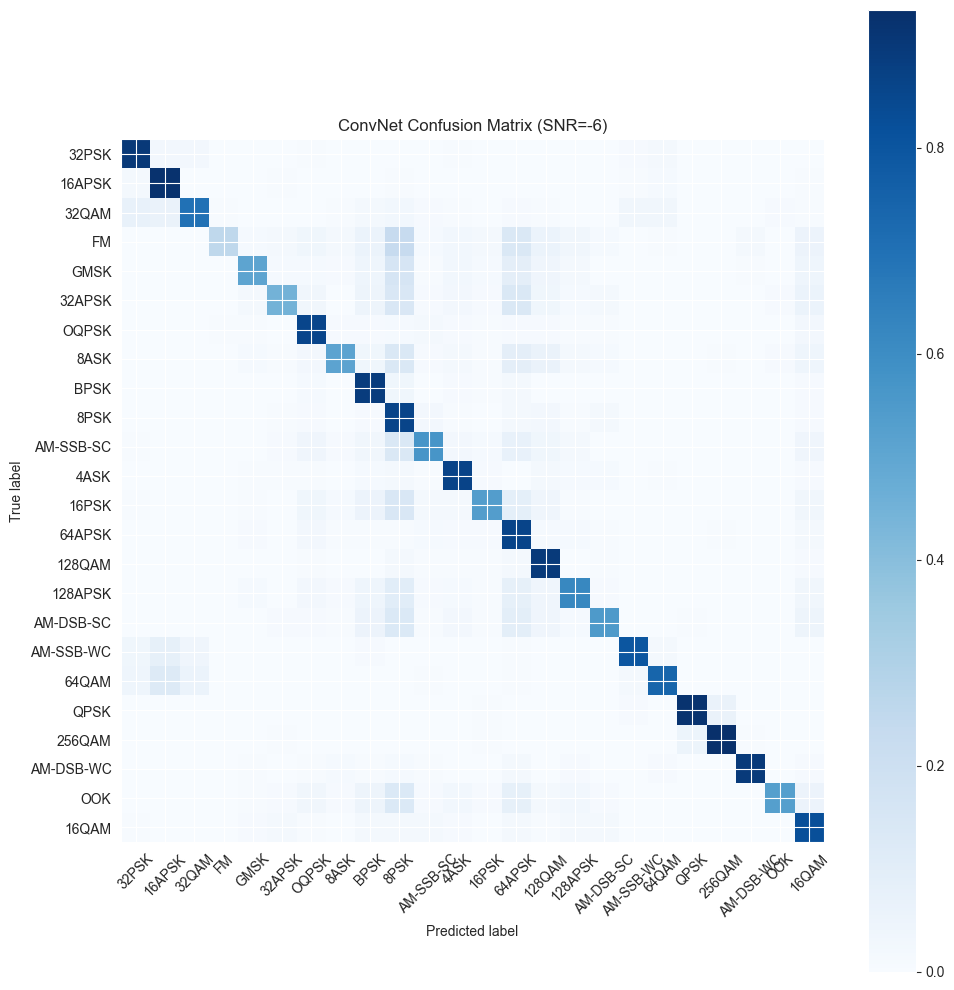

<Figure size 640x480 with 0 Axes>

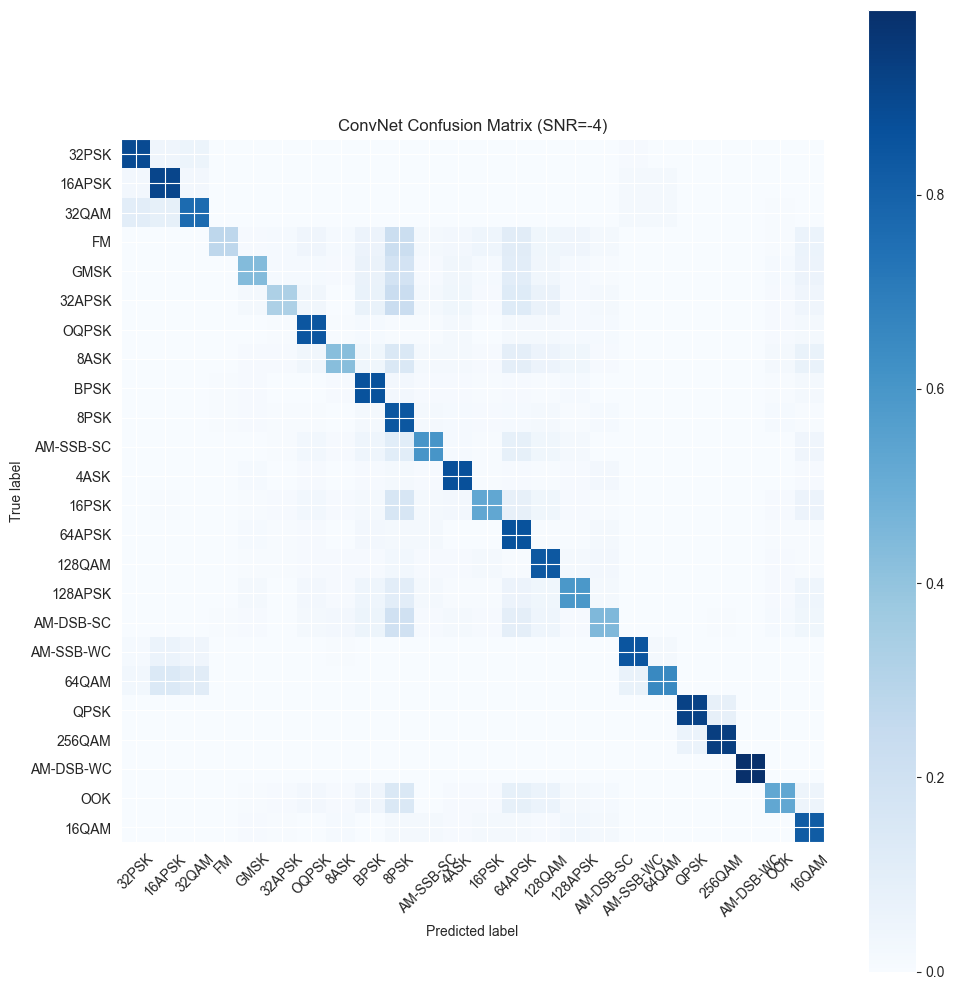

<Figure size 640x480 with 0 Axes>

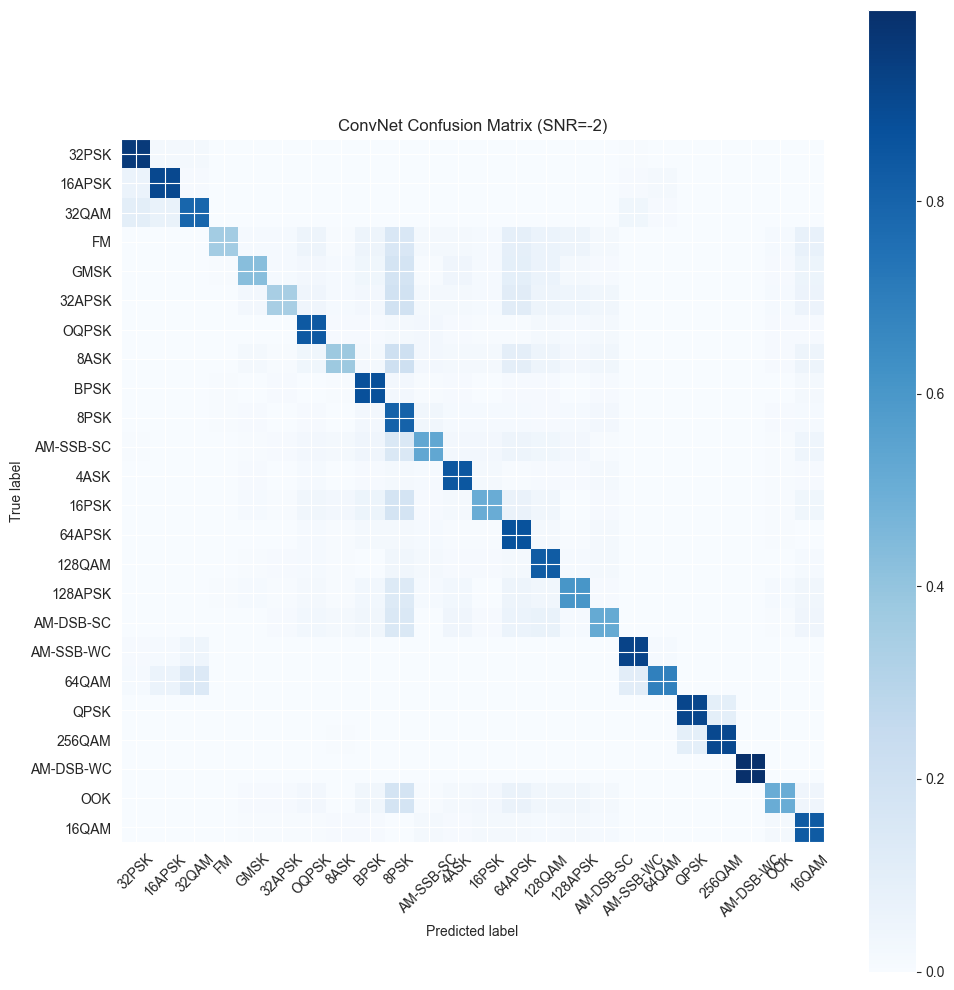

<Figure size 640x480 with 0 Axes>

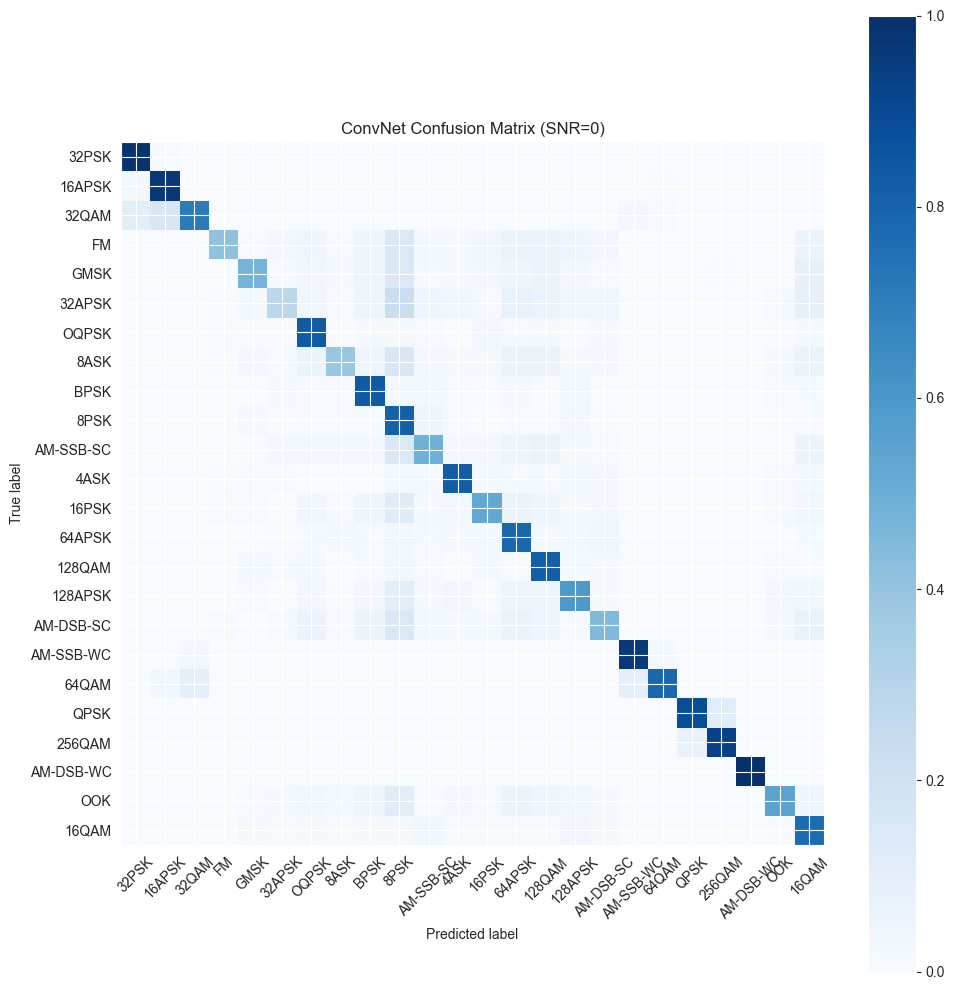

<Figure size 640x480 with 0 Axes>

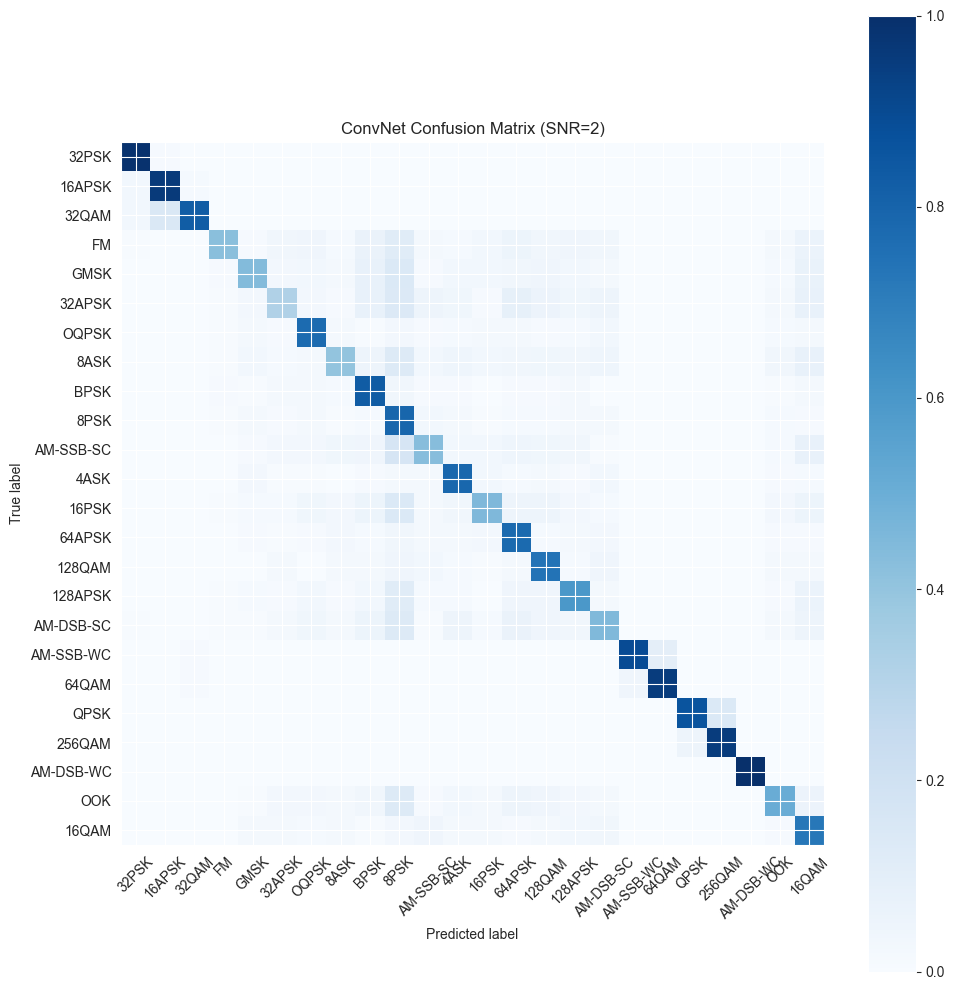

<Figure size 640x480 with 0 Axes>

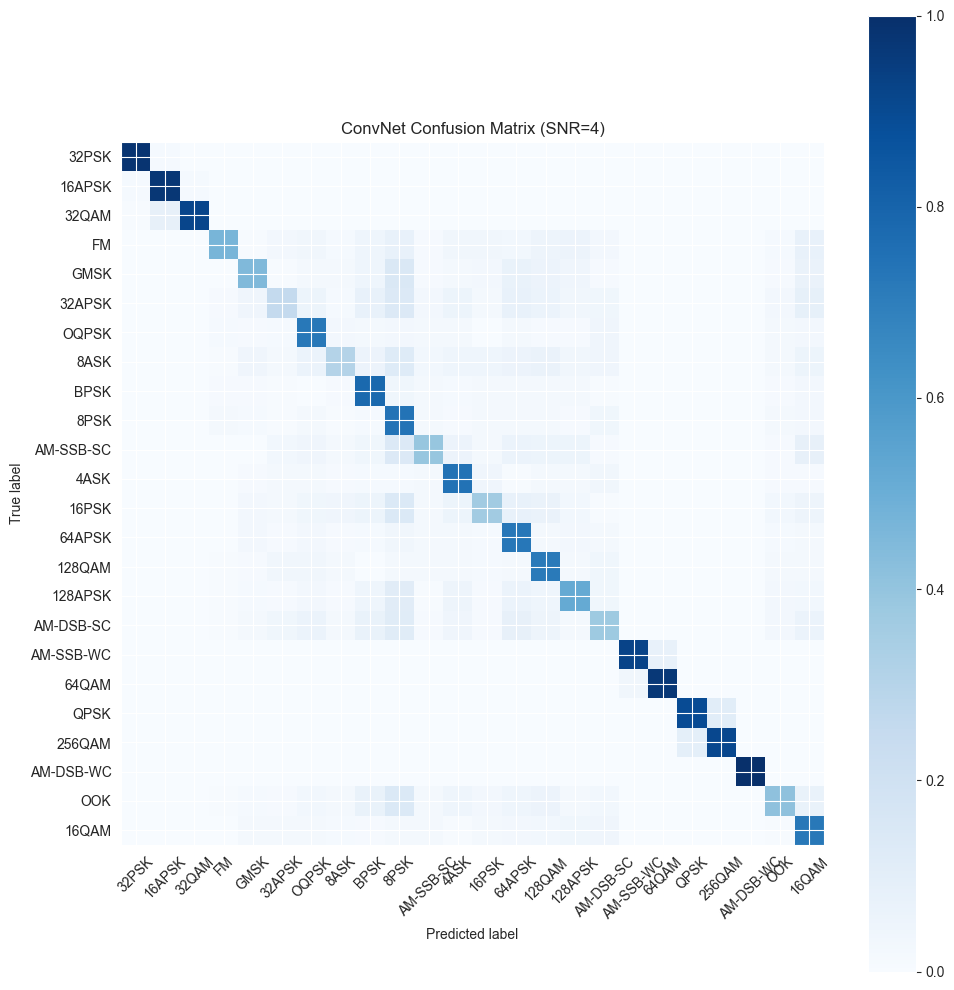

<Figure size 640x480 with 0 Axes>

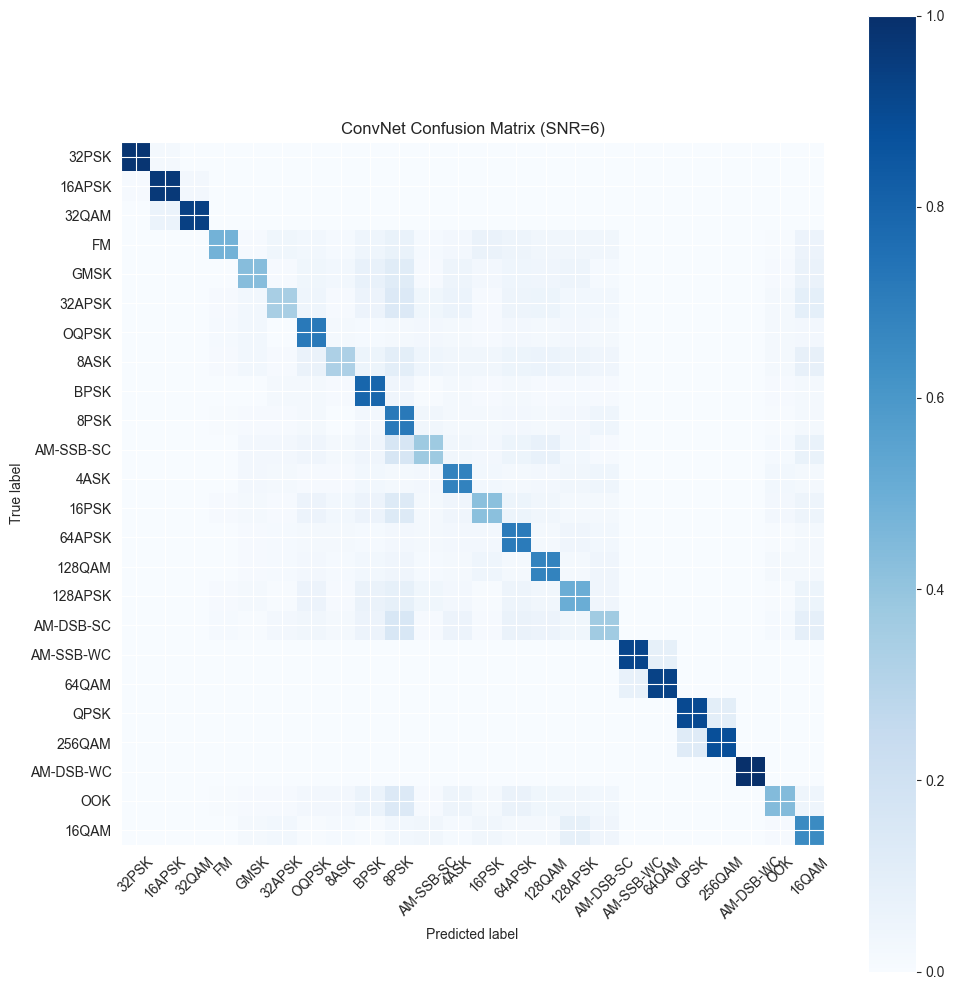

<Figure size 640x480 with 0 Axes>

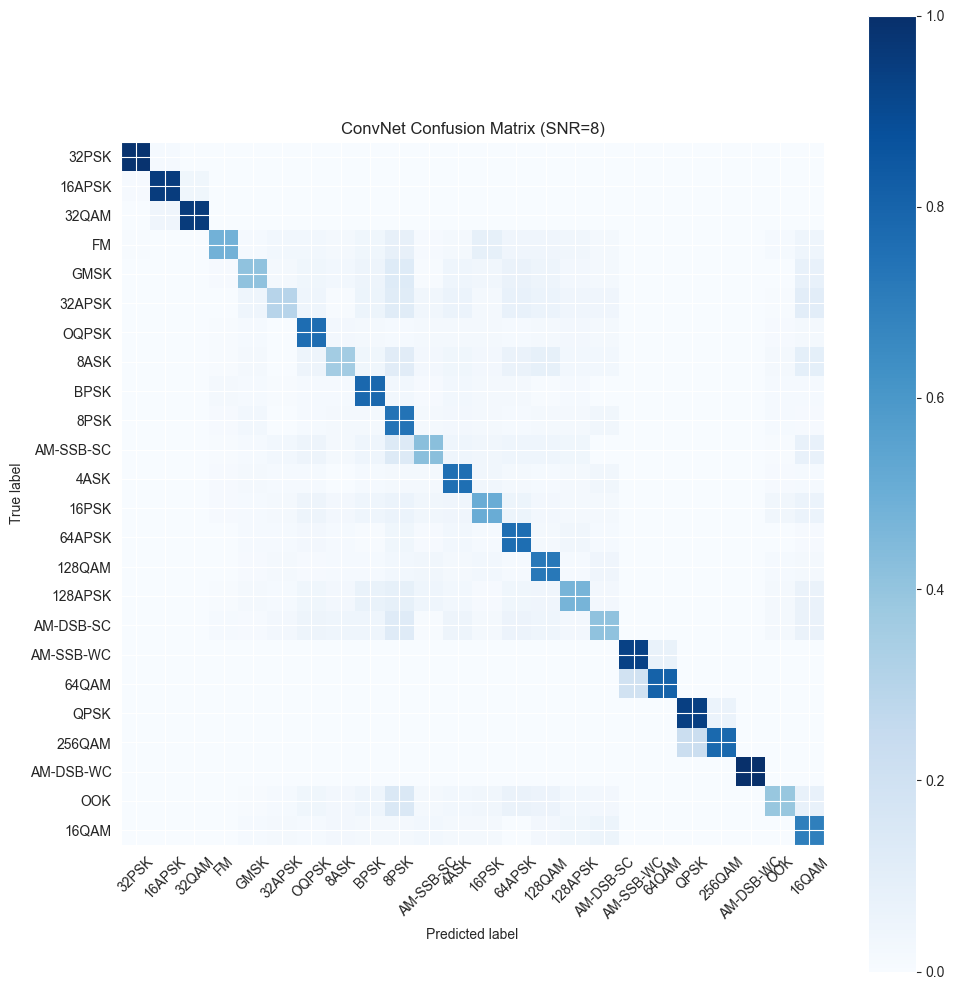

<Figure size 640x480 with 0 Axes>

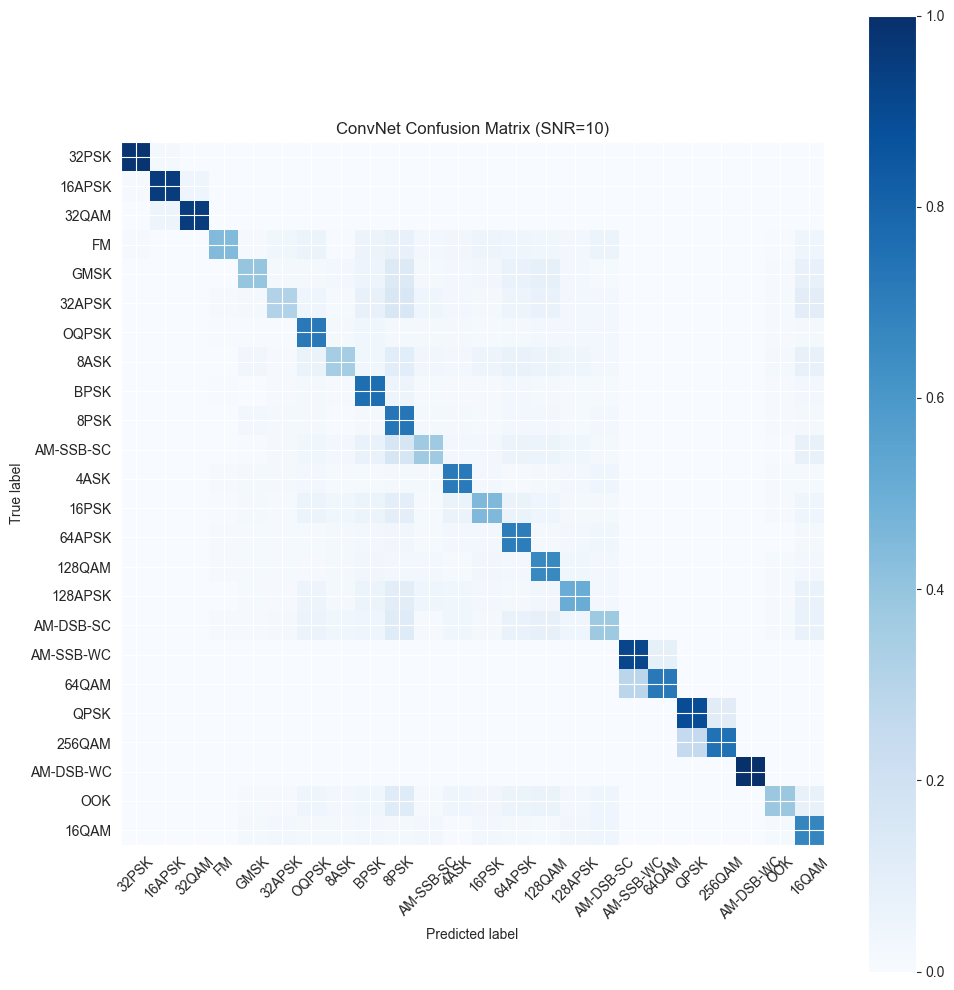

<Figure size 640x480 with 0 Axes>

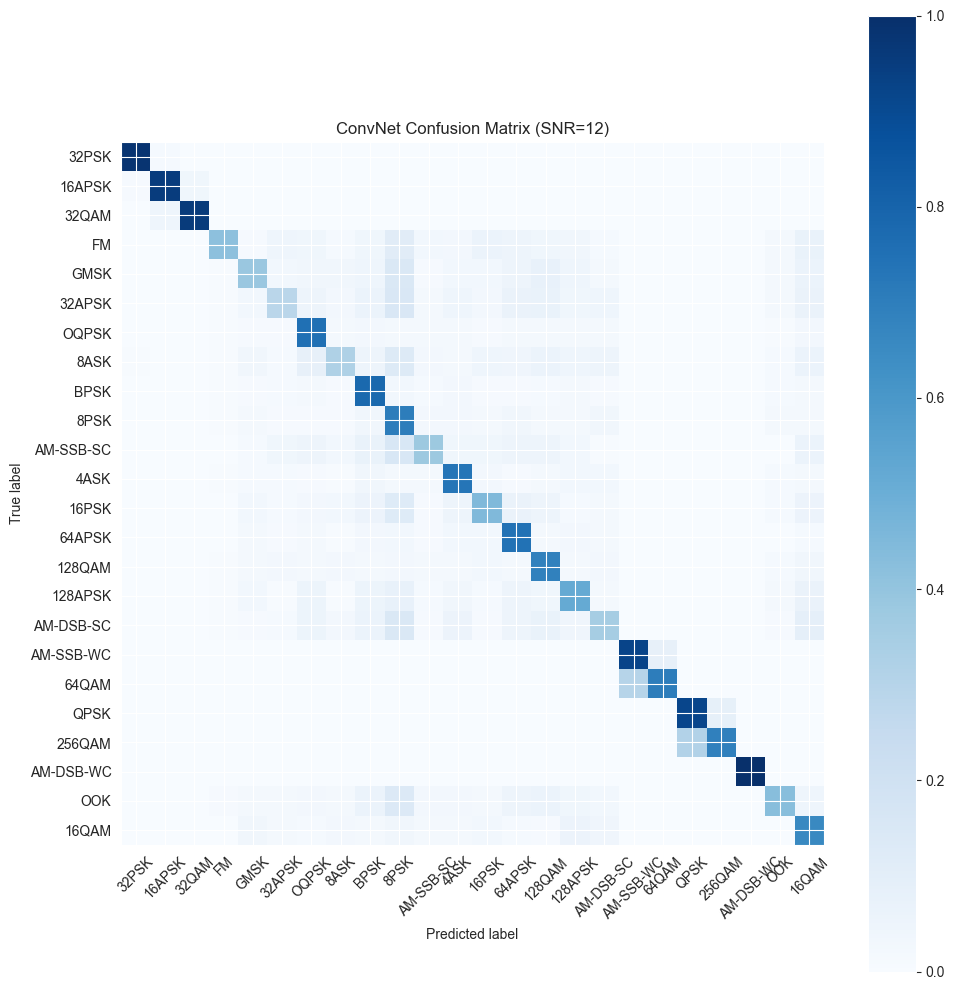

<Figure size 640x480 with 0 Axes>

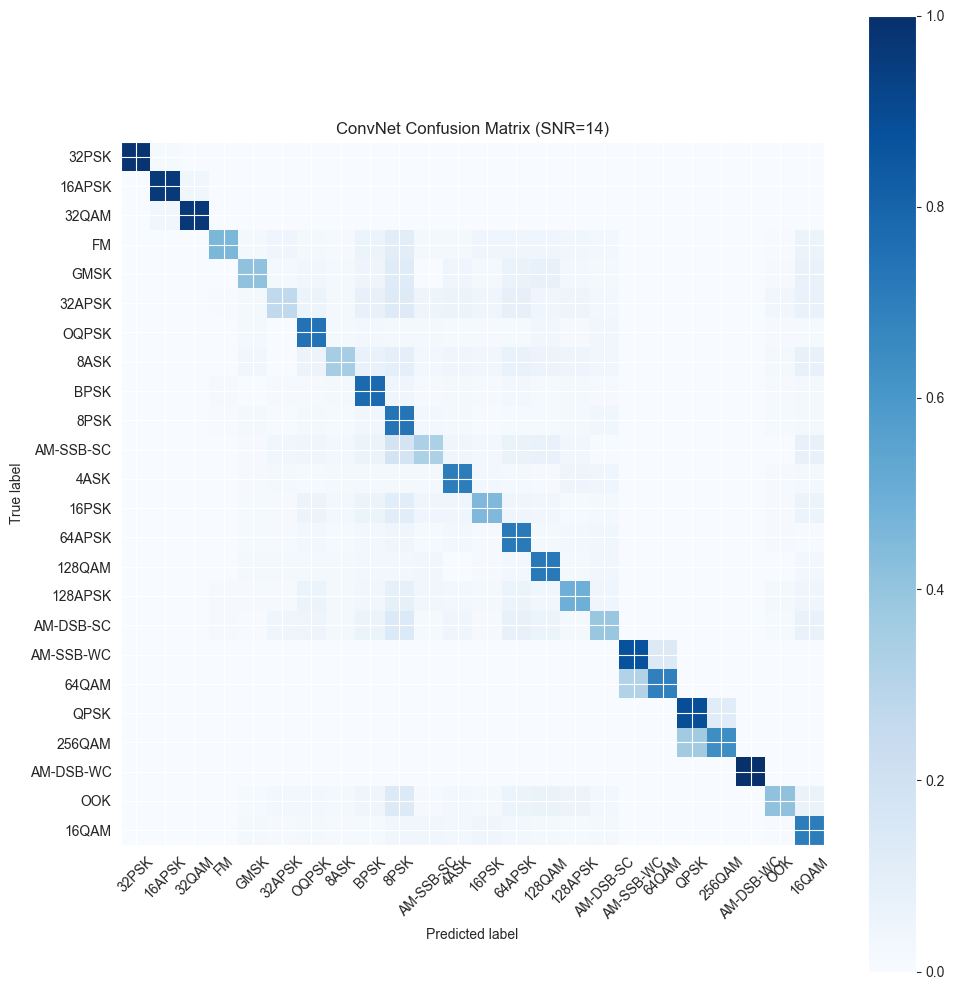

<Figure size 640x480 with 0 Axes>

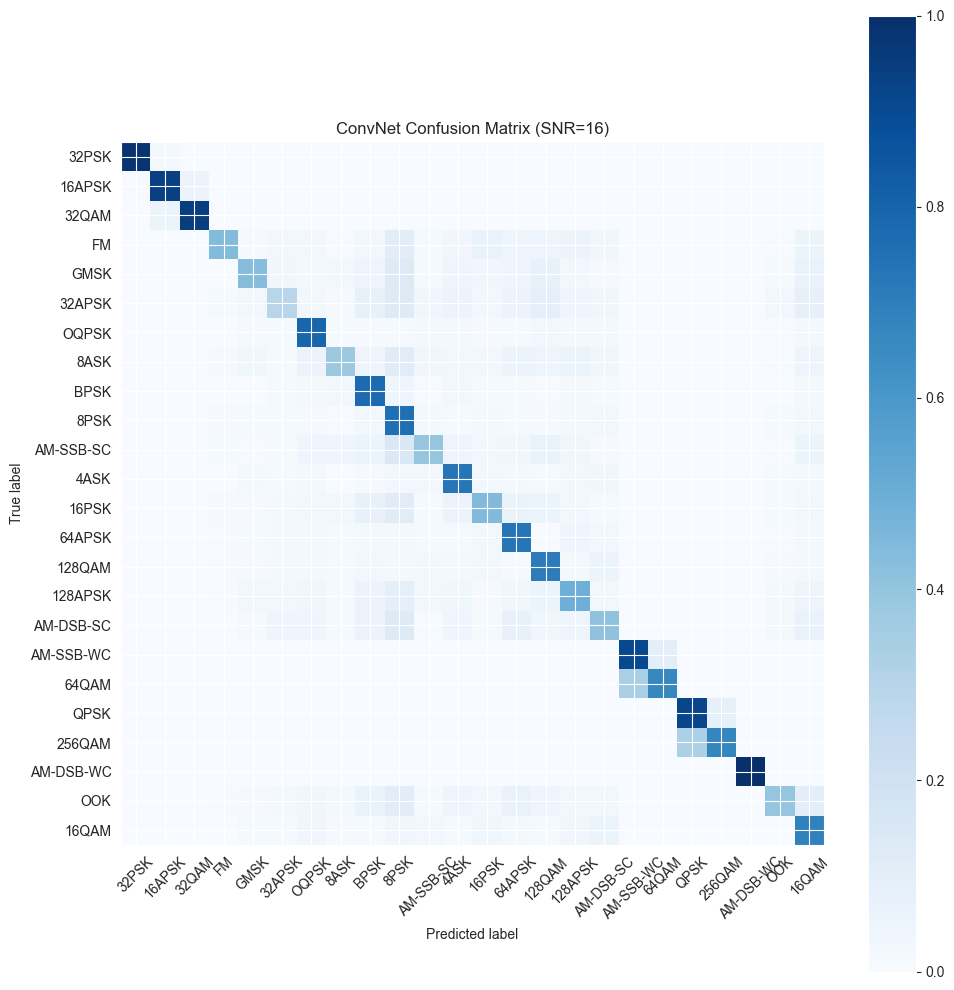

<Figure size 640x480 with 0 Axes>

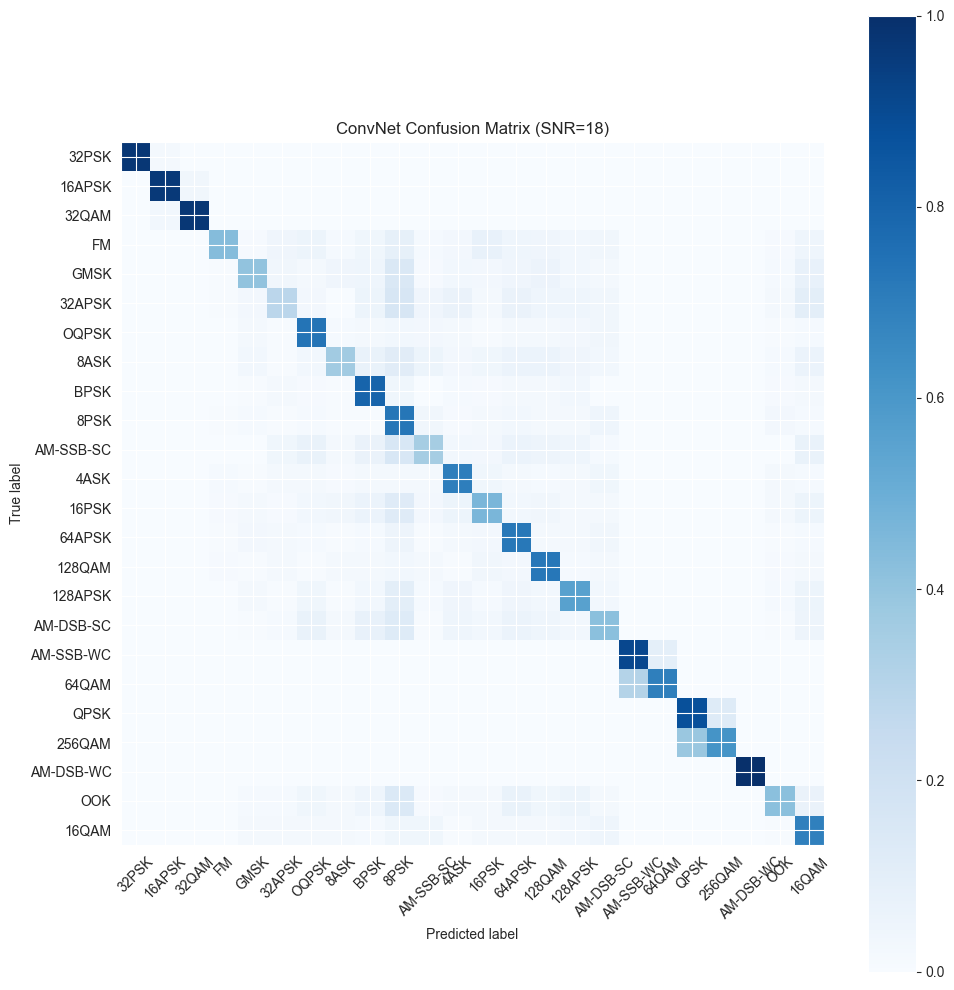

<Figure size 640x480 with 0 Axes>

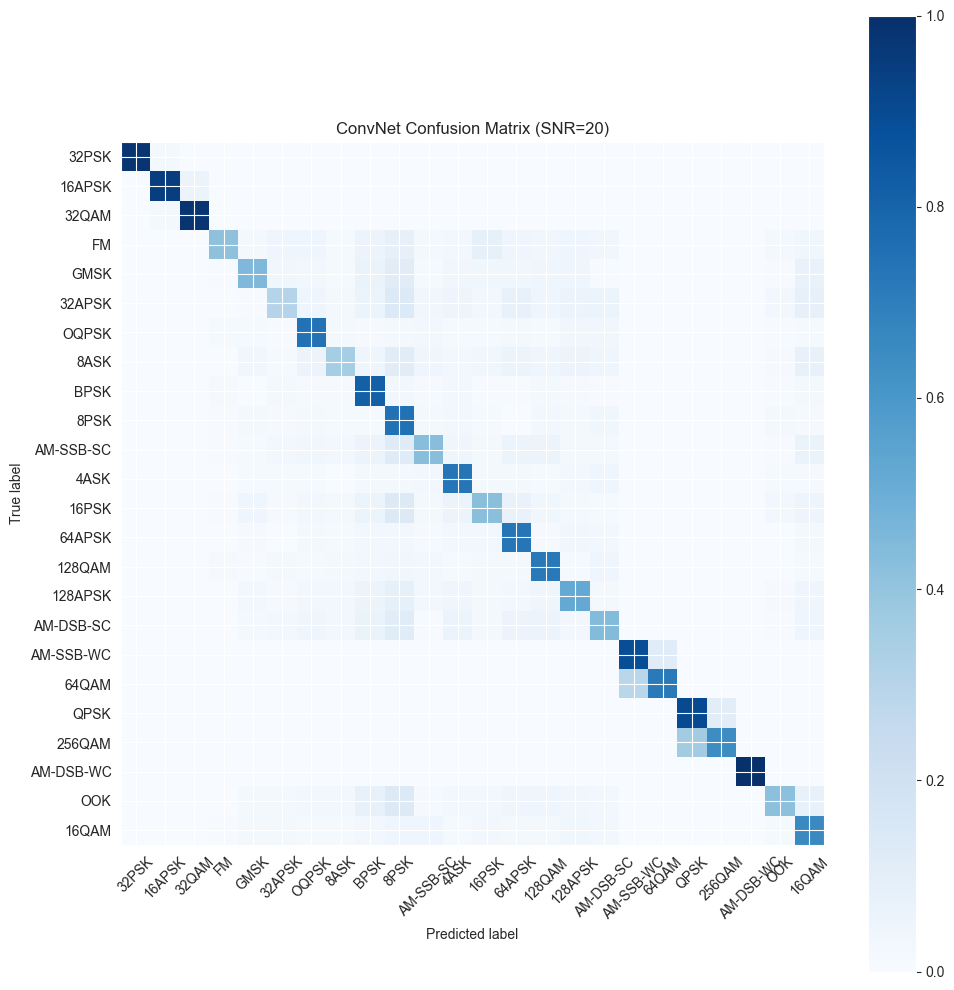

<Figure size 640x480 with 0 Axes>

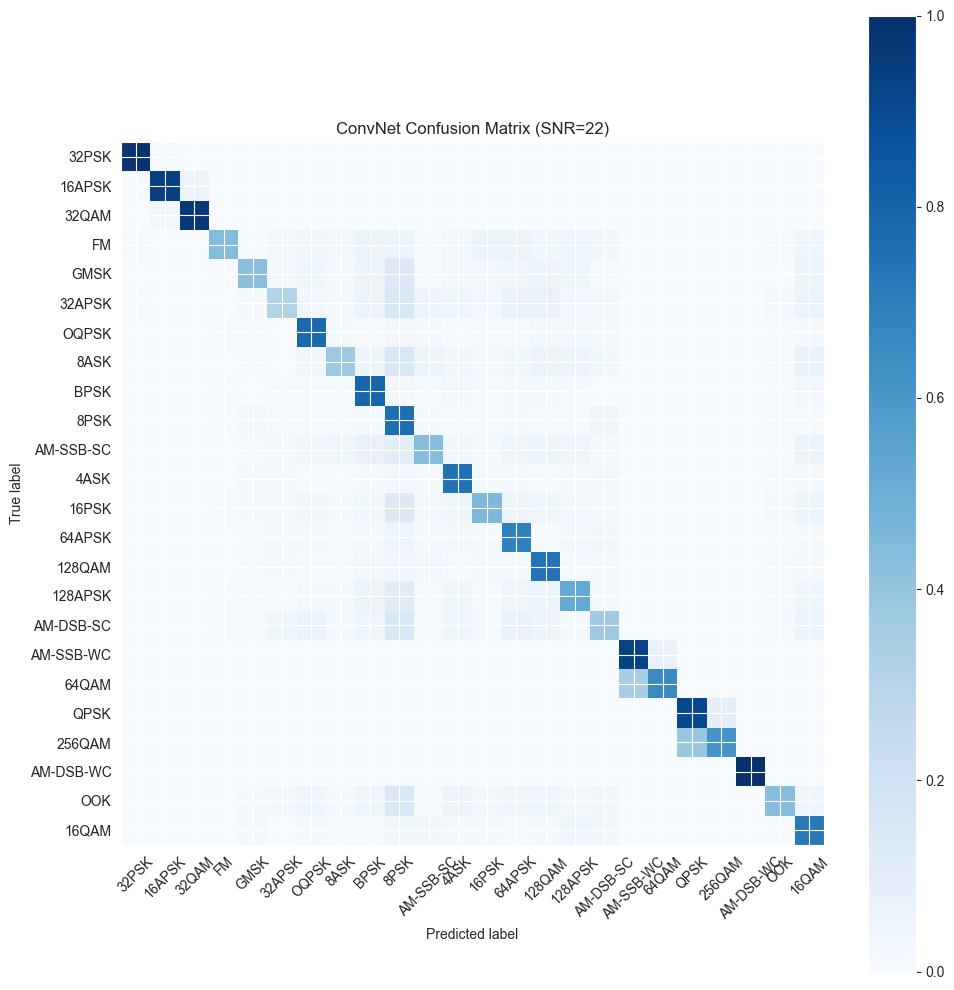

<Figure size 640x480 with 0 Axes>

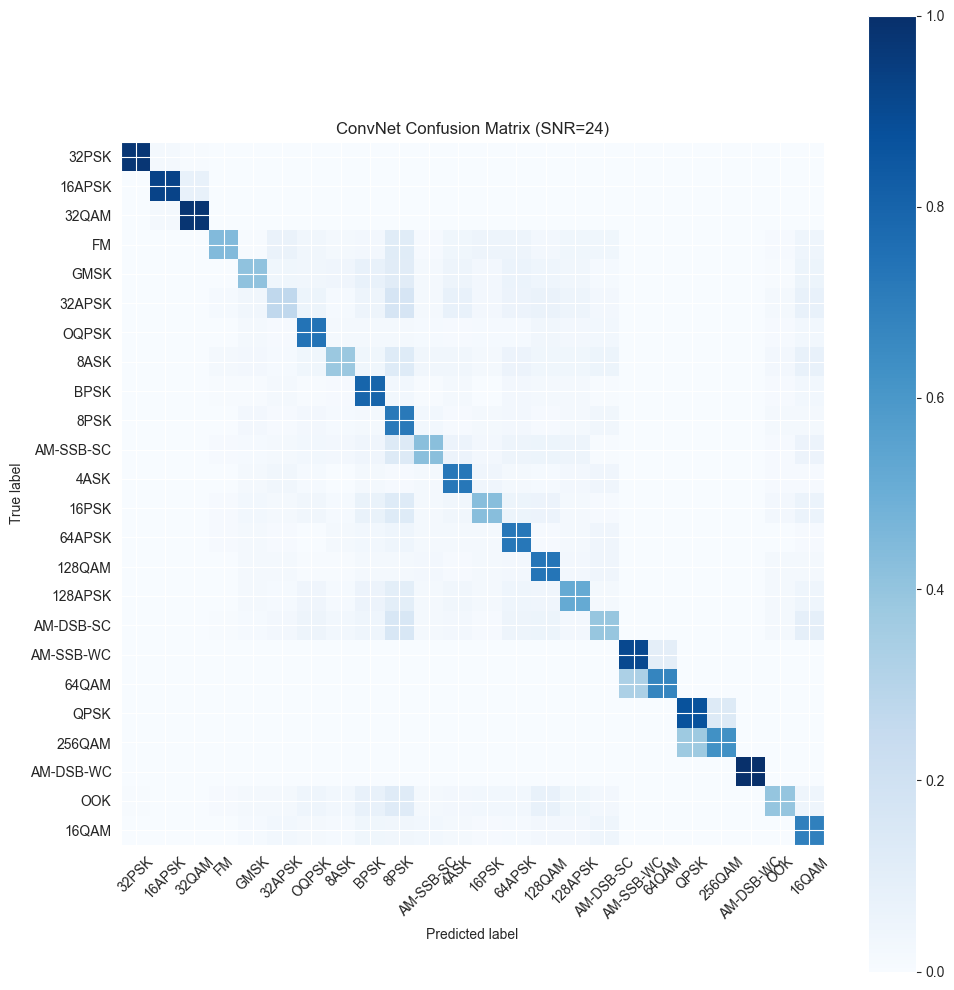

<Figure size 640x480 with 0 Axes>

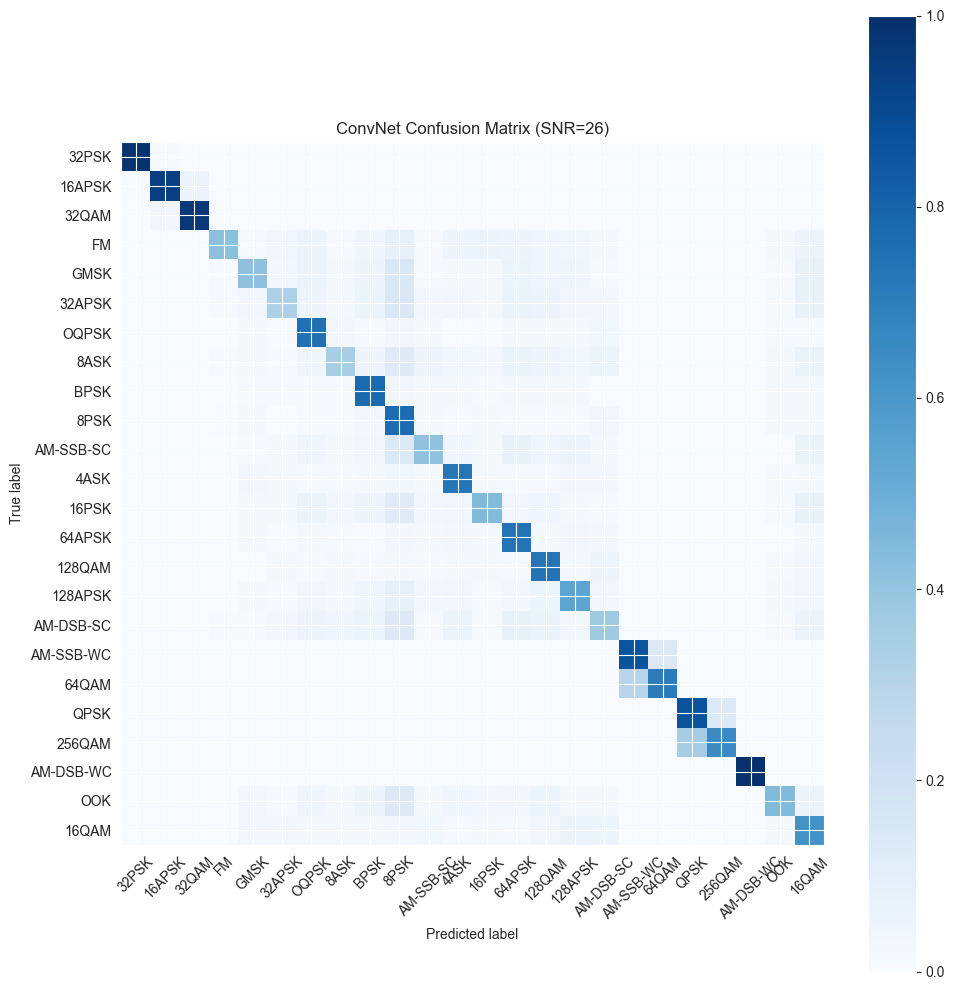

<Figure size 640x480 with 0 Axes>

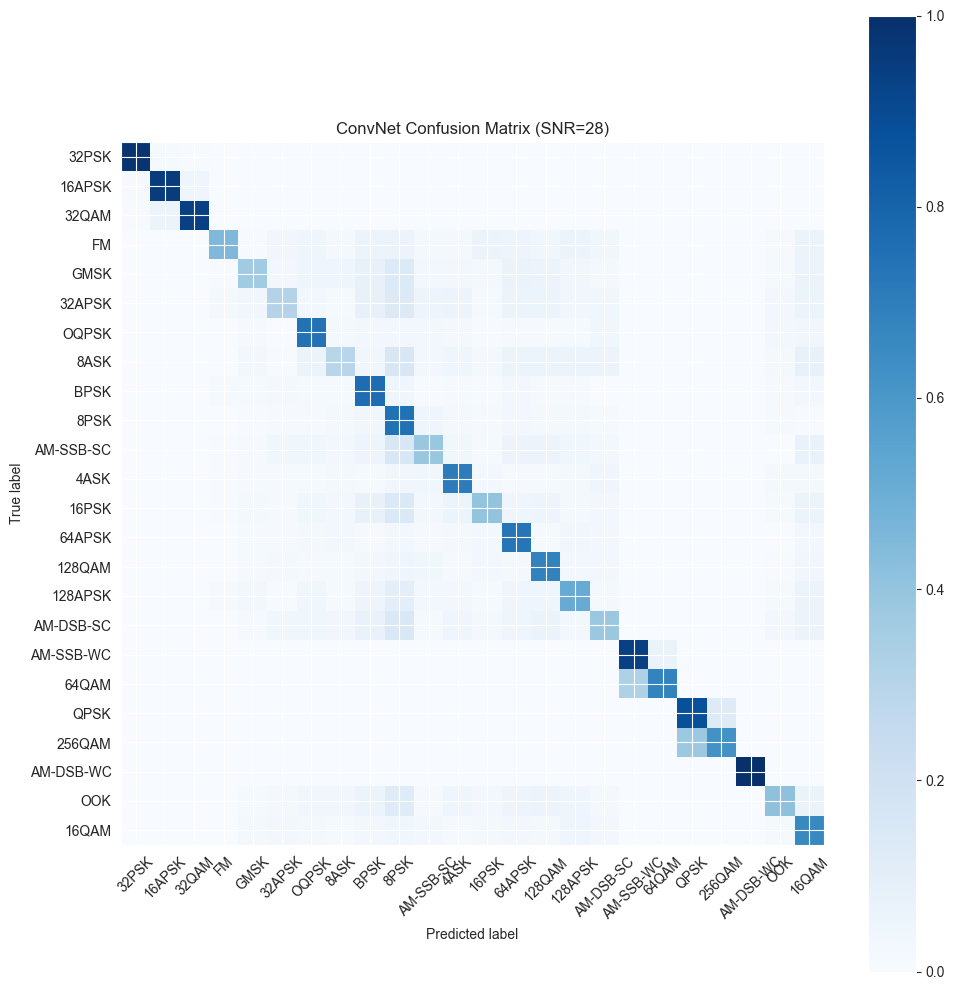

<Figure size 640x480 with 0 Axes>

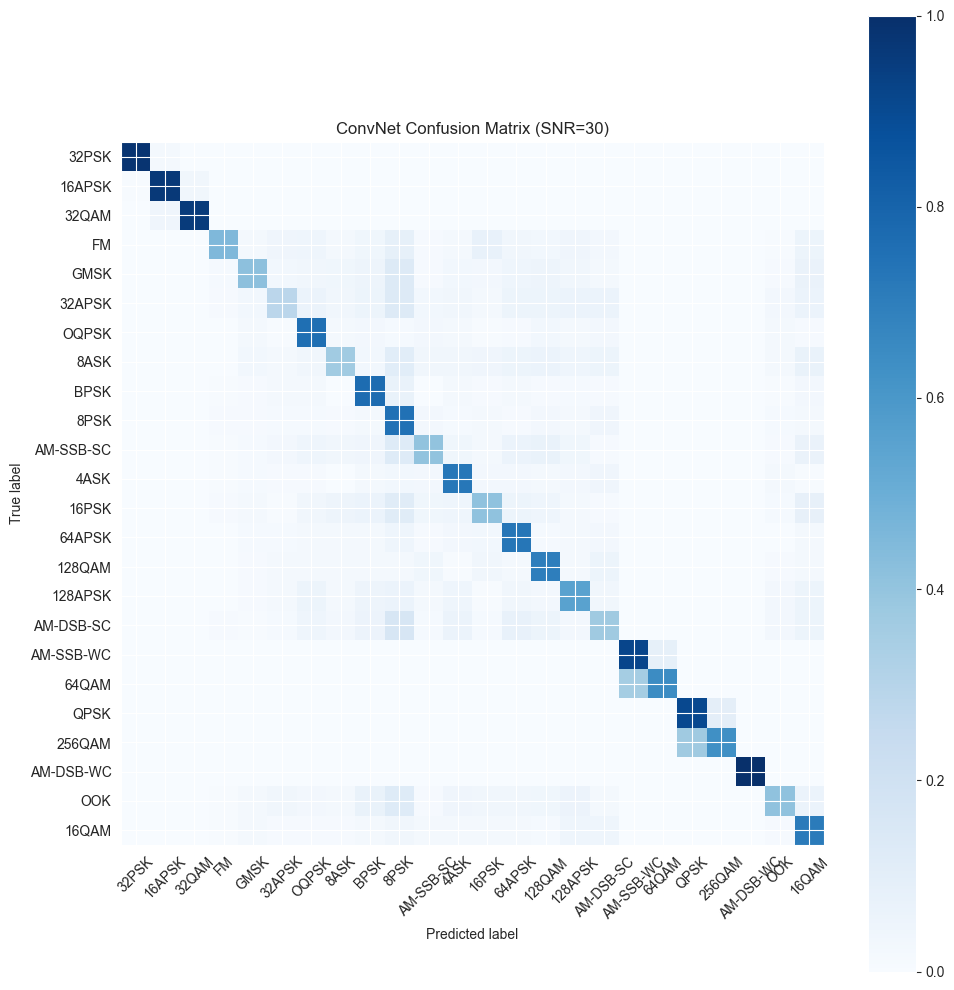

In [44]:
acc={}
SNRs = range(-20, 31, 2)
outputs_test = []
y_true = []
y_pred = []
model.eval()

for snr in SNRs:
    with torch.no_grad():
        for inputs, labels, snr_dataset in test_loader:
            inputs, labels, snr_dataset = inputs.to(device), labels.to(device), snr_dataset.to(device)
            indices = torch.where(snr_dataset == snr)
            X_test_snr = inputs[indices[0],:,:]
            Y_test_snr = labels[indices[0],:]
            outputs = model(X_test_snr)
            _, predicted = outputs.max(1)
            y_true.extend(Y_test_snr.max(1)[1].cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, len(y_true)):
        j = y_true[i]
        k = y_pred[i]
        conf[j, k] += 1

    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title=f"ConvNet Confusion Matrix (SNR={snr})")

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print(f"Overall Accuracy {snr}: ", cor / (cor + ncor))
    acc[snr] = cor / (cor + ncor)
    y_true = []
    y_pred = []

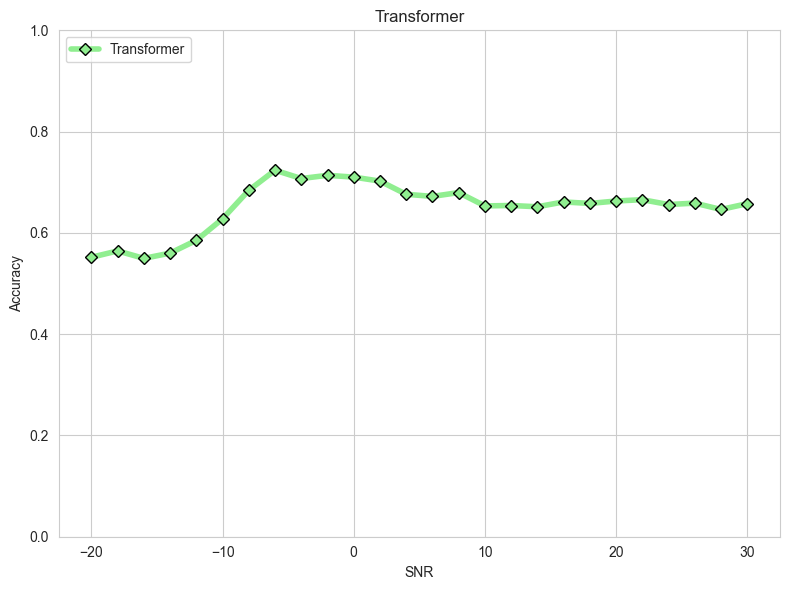

In [46]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Transformer')
plt.tight_layout()
plt.legend(['Transformer'],loc='upper left')
plt.show()